In [157]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.features import PCA as ybPCA
import scipy.cluster.hierarchy as sch
import warnings
warnings.filterwarnings("ignore")

#### Vamos aplicar PCA aos dados

In [158]:
# leitura e exclusão de Myanmar
country = pd.read_csv("../data/Country-data.csv", index_col='country')
country.drop(labels="Myanmar", axis=0, inplace=True)

In [159]:
# definição de variáveis para uso nos modelos
X1 = 'income'
X2 = 'gdpp'
vars = ['income', 'gdpp']

In [160]:
# standardScaler, fit e transform nas variáveis
scaler = StandardScaler()
scaler.fit(country)
country_scaled = pd.DataFrame(scaler.transform(country), columns=country.columns, index=country.index)

#### Como explicado na análise exploratória, vamos usar duas componetes da PCA

In [161]:
# modelo, fit e transform das variáveis
pca = PCA(n_components=2)
pca.fit(country_scaled)
country_pca = pd.DataFrame(pca.transform(country_scaled), columns=(["col_1", "col_2"]))

In [162]:
# criação do modelo, fit e predict 
model_pca = KMeans(n_clusters=3,
                    n_init=100,
                    max_iter=1000,
                    random_state=42)

model_pca.fit(country_pca)
country_pca['clusters'] = model_pca.predict(country_pca)

# centroid dos clusters
centroids_pca = model_pca.cluster_centers_

In [163]:
# clusters encontrados
cluster_0 = country_pca[country_pca['clusters'] == 0]
cluster_1 = country_pca[country_pca['clusters'] == 1]
cluster_2 = country_pca[country_pca['clusters'] == 2]

# visualização do tamanho
print(f"""Cluster 0: {len(cluster_0)}
Cluster 1: {len(cluster_1)}
Cluster 2: {len(cluster_2)}""")

Cluster 0: 3
Cluster 1: 92
Cluster 2: 71


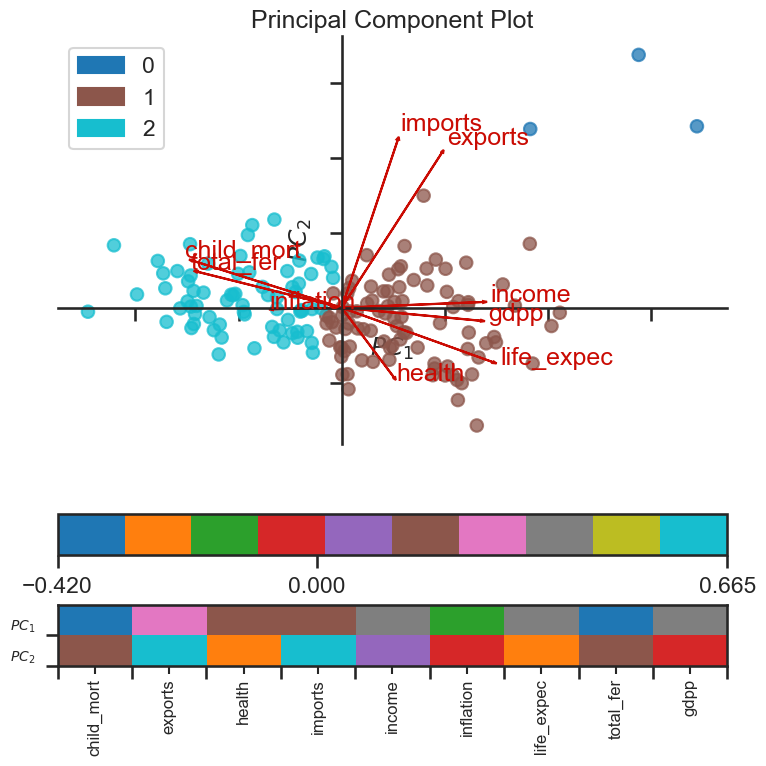

In [164]:
# plot dos clusters de acordo com as duas componentes da PCA
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.spines["left"].set_position("zero")
ax.spines["bottom"].set_position("zero")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.grid(False)

visualizer = ybPCA(scale=True, proj_features=True, heatmap=True, colormap="tab10")
visualizer.fit_transform(country, country_pca['clusters'])

_ = visualizer.show()

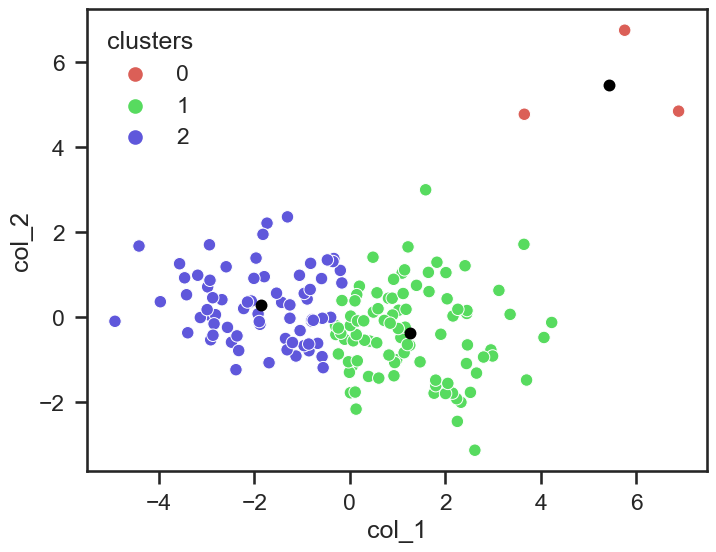

In [165]:
# plot com os cluster e os centroids
plt.figure(figsize = (8,6))
sns.scatterplot(data = country_pca,
                x = 'col_1',
                y = 'col_2',
                hue = country_pca['clusters'],
                palette = sns.color_palette('hls', 3))
plt.scatter(centroids_pca[:,0],
            centroids_pca[:,1],
            c = 'black',
            s = 50)
plt.show()

In [166]:
# cálculo das distancias para o centroid
cluster_0['dist_2'] = (cluster_0['col_1']-centroids_pca[0,0])**2 + (cluster_0['col_2']-centroids_pca[0,1])**2
cluster_1['dist_2'] = (cluster_1['col_1']-centroids_pca[0,0])**2 + (cluster_1['col_2']-centroids_pca[0,1])**2
cluster_2['dist_2'] = (cluster_2['col_1']-centroids_pca[0,0])**2 + (cluster_2['col_2']-centroids_pca[0,1])**2
index_min_0 = cluster_0['dist_2'][cluster_0['dist_2'] == cluster_0['dist_2'].min()].index
index_min_1 = cluster_1['dist_2'][cluster_1['dist_2'] == cluster_1['dist_2'].min()].index
index_min_2 = cluster_2['dist_2'][cluster_2['dist_2'] == cluster_2['dist_2'].min()].index

In [167]:
print(f"""Os 3 países que representam os cluster nos dados com PCA são:
Cluster 0: {country.iloc[index_min_0[0]].name}
Cluster 1: {country.iloc[index_min_1[0]].name}
Cluster 2: {country.iloc[index_min_2[0]].name}""")

Os 3 países que representam os cluster nos dados com PCA são:
Cluster 0: Singapore
Cluster 1: Ireland
Cluster 2: Guyana


_____________________

In [168]:
# análise para ver a melhor opção entre os métodos de linkage para o modelo te clusterização aglomerativa
linkage = ['ward', 'complete', 'average', 'single']
distribuicao =[]
for i in range(0,4):
    model_aglo_pca = AgglomerativeClustering(n_clusters=3, linkage=linkage[i]).fit(country_pca)
    count = model_aglo_pca.labels_
    distribuicao.append(count)
   
distribuicao = pd.DataFrame(distribuicao)

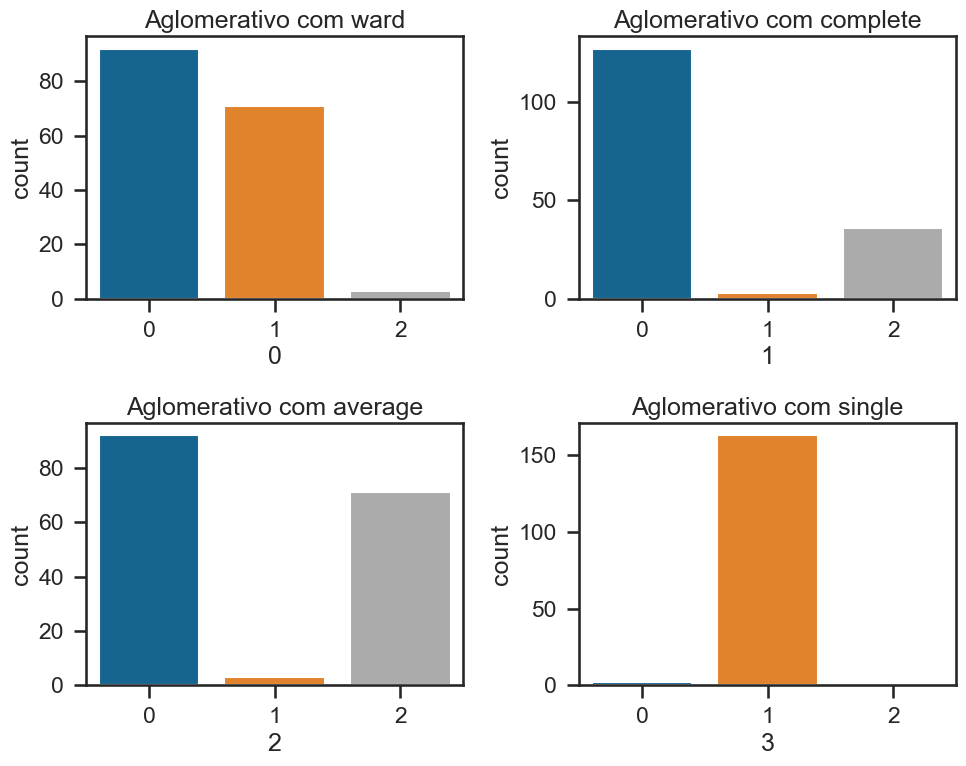

In [169]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(221)
sns.countplot(x=distribuicao.T[0])
ax.set_title('Aglomerativo com ward')

ax = fig.add_subplot(222)
sns.countplot(x=distribuicao.T[1])
ax.set_title('Aglomerativo com complete')

ax = fig.add_subplot(223)
sns.countplot(x=distribuicao.T[2])
ax.set_title('Aglomerativo com average')

ax = fig.add_subplot(224)
sns.countplot(x=distribuicao.T[3])
ax.set_title('Aglomerativo com single')

plt.tight_layout()
plt.show()

#### De acordo com o gráfico acima, podemos ver que os parâmetros "ward" e "average" são muito parecidos para o algoritmo de clusterização. Neste caso, vamos continar com o parâmetro "ward" igual aos outros modelos

Text(0, 0.5, 'Distancias')

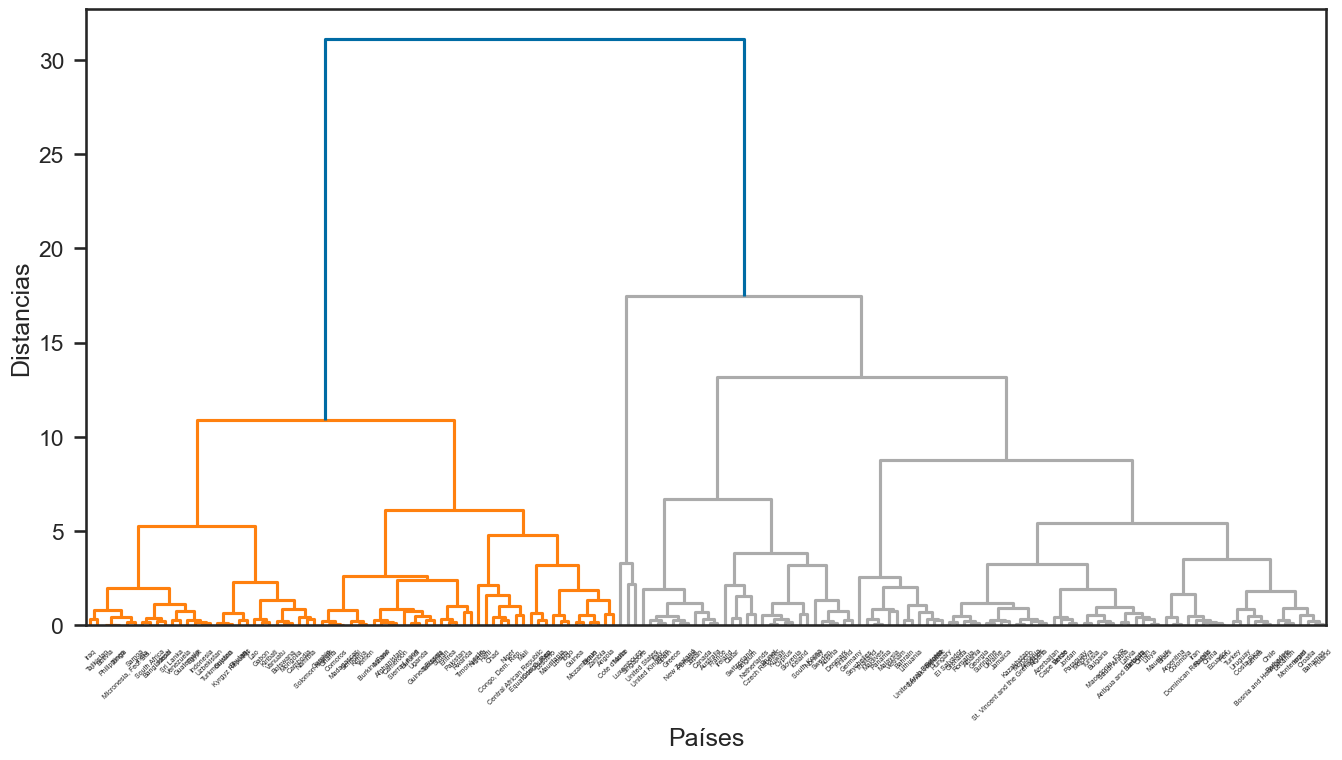

In [170]:
plt.style.use('tableau-colorblind10')
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

linkage = sch.linkage(country_pca, method="ward")
dendrogram = sch.dendrogram(linkage, labels=country_scaled.index, leaf_rotation=45)

ax.set_xlabel('Países')
ax.set_ylabel('Distancias')

#### Neste caso, embora tenhamos distâncias pequenas, tivemos apenas dois clusters inferiores (talvez pelas duas componentes)

______________

#### Abaixo, vamos analisar os medoids. Ao invés de termos centroids de cada cluster e seus pontos mais próximos, os medoidos são os pontos existentes que representam o centro de cada cluster.

In [171]:
# fit e predict do modelo com 3 clusters
model_medoid_pca = KMedoids(n_clusters=3, max_iter=1000, random_state=42)
model_medoid_pca.fit(country_pca)
country_pca['clusters_medoid'] = model_medoid_pca.predict(country_pca)

# medoids
medoids = model_medoid_pca.cluster_centers_

In [172]:
# clusters encontrados
cluster_0 = country_pca[country_pca['clusters_medoid'] == 0]
cluster_1 = country_pca[country_pca['clusters_medoid'] == 1]
cluster_2 = country_pca[country_pca['clusters_medoid'] == 2]

# visualização do tamanho de cada cluster
print(f"""Cluster 0: {len(cluster_0)}
Cluster 1: {len(cluster_1)}
Cluster 2: {len(cluster_2)}""")

Cluster 0: 48
Cluster 1: 58
Cluster 2: 60


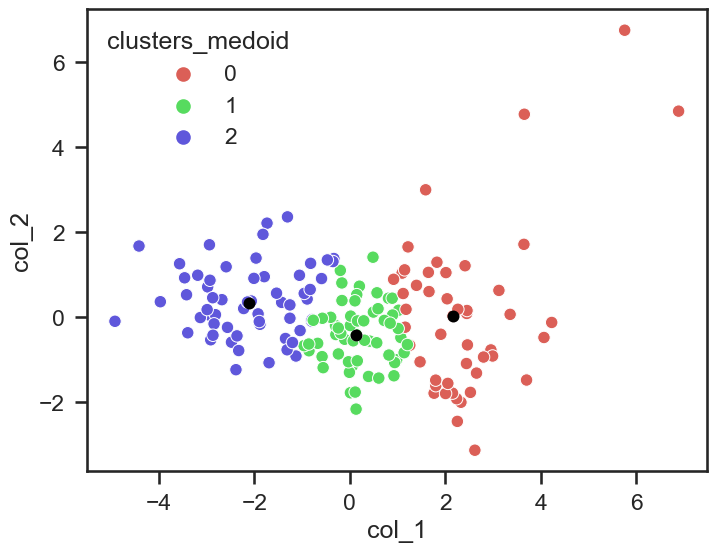

In [173]:
#plot dos clusters e seus medoids
plt.figure(figsize = (8,6))
sns.scatterplot(data = country_pca,
                x = 'col_1',
                y = 'col_2',
                hue = country_pca['clusters_medoid'],
                palette = sns.color_palette('hls', 3))
plt.scatter(medoids[:,0],
            medoids[:,1],
            c = 'black',
            s = 50)
plt.show()

In [174]:
# cálculo das distancias para o medoid
cluster_0['dist_2'] = (cluster_0['col_1']-medoids[0,0])**2 + (cluster_0['col_2']-medoids[0,1])**2
cluster_1['dist_2'] = (cluster_1['col_1']-medoids[0,0])**2 + (cluster_1['col_2']-medoids[0,1])**2
cluster_2['dist_2'] = (cluster_2['col_1']-medoids[0,0])**2 + (cluster_2['col_2']-medoids[0,1])**2
index_min_0 = cluster_0['dist_2'][cluster_0['dist_2'] == cluster_0['dist_2'].min()].index
index_min_1 = cluster_1['dist_2'][cluster_1['dist_2'] == cluster_1['dist_2'].min()].index
index_min_2 = cluster_2['dist_2'][cluster_2['dist_2'] == cluster_2['dist_2'].min()].index

In [175]:
print(f"""Os 3 países que representam os cluster nos dados com PCA usando Medoids são:
Cluster 0: {country.iloc[index_min_0[0]].name}
Cluster 1: {country.iloc[index_min_1[0]].name}
Cluster 2: {country.iloc[index_min_2[0]].name}""")

Os 3 países que representam os cluster nos dados com PCA usando Medoids são:
Cluster 0: Cyprus
Cluster 1: Antigua and Barbuda
Cluster 2: Kyrgyz Republic


#### Tivemos aqui uma diferença nos medoids. Temos dois países em desenvolvimento (Antigua e Barbuda & Quirquistão) e Chipre como um país desenvolvido